### Testing the model for SERS

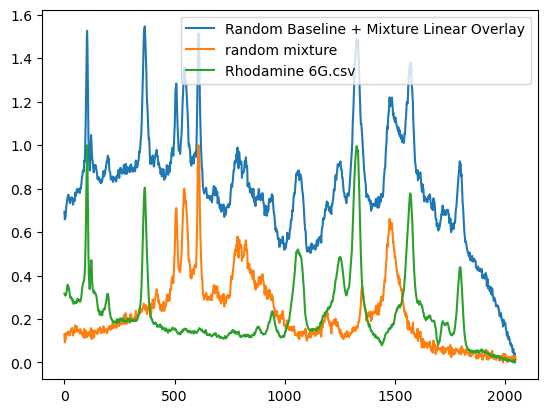

**********************************************
Rhodamine 6G
输出标签为： [0.075 0.798 0.127]
*******
预测的化学品为： ['Rhodamine 6G', 'Crystal Violet']
参比分数为： [0.798, 0.127]
**********************************************


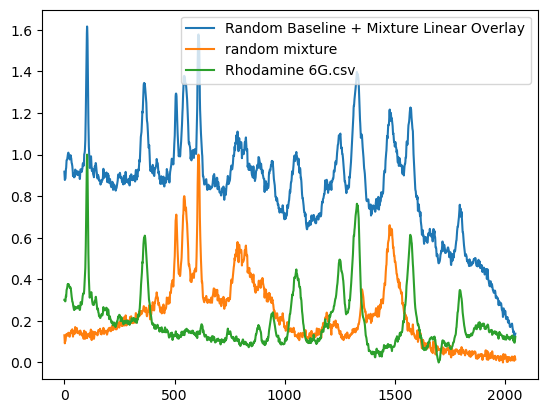

**********************************************
Rhodamine 6G
输出标签为： [0.076 0.775 0.149]
*******
预测的化学品为： ['Rhodamine 6G', 'Crystal Violet']
参比分数为： [0.775, 0.149]
**********************************************


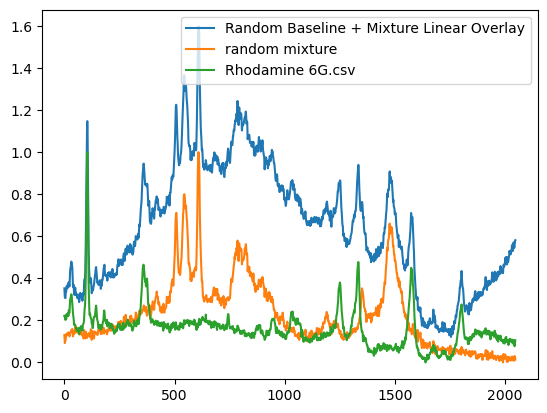

**********************************************
Rhodamine 6G
输出标签为： [0.107 0.661 0.233]
*******
预测的化学品为： ['Rhodamine 6G', 'Crystal Violet', 'Methylene Blue']
参比分数为： [0.661, 0.233, 0.107]
**********************************************


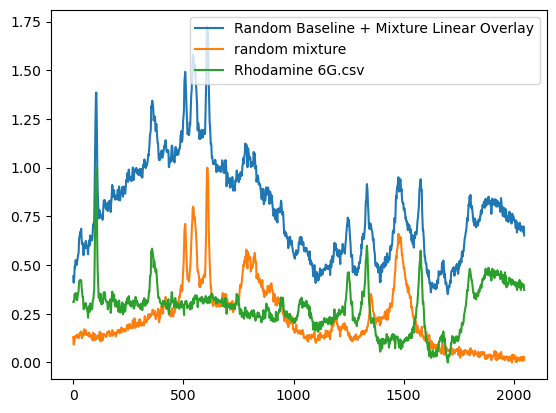

**********************************************
Rhodamine 6G
输出标签为： [0.098 0.693 0.21 ]
*******
预测的化学品为： ['Rhodamine 6G', 'Crystal Violet', 'Methylene Blue']
参比分数为： [0.693, 0.21, 0.098]
**********************************************


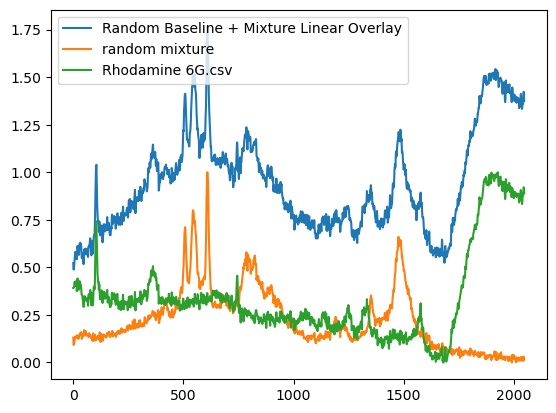

**********************************************
Rhodamine 6G
输出标签为： [0.171 0.504 0.325]
*******
预测的化学品为： ['Rhodamine 6G', 'Crystal Violet', 'Methylene Blue']
参比分数为： [0.504, 0.325, 0.171]
**********************************************


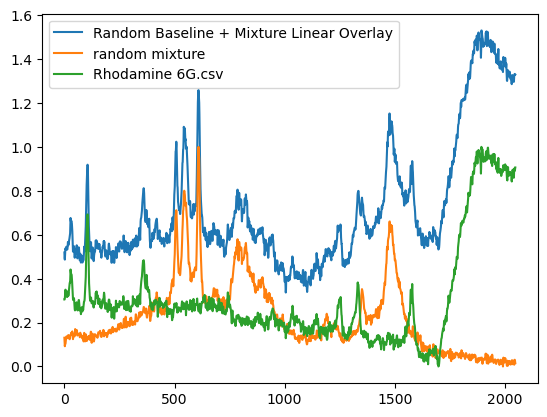

**********************************************
Rhodamine 6G
输出标签为： [0.171 0.531 0.298]
*******
预测的化学品为： ['Rhodamine 6G', 'Crystal Violet', 'Methylene Blue']
参比分数为： [0.531, 0.298, 0.171]
**********************************************


<Figure size 640x480 with 0 Axes>

In [4]:
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy import spatial
import os
import time
import torch
import torch.nn as nn
from scipy.signal import savgol_filter
import ml_collections
import torch.nn.functional as F
from sers_cnn_mixnet import *
import matplotlib.pyplot as plt
def set_config():
    """
    Return the init configuration.
    """
    config = ml_collections.ConfigDict()
    #config.patches = ml_collections.ConfigDict({'size':16})
    config.hidden_size = 128
    config.channel_size = 128
    #config.channel_size = 64
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 256
    config.transformer.num_heads = 8
    config.transformer.num_layers = 16
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    return config
config = set_config()
#from function import pull_baseline
def similar_data(data_1,data_2):#做个相似度对比一下
    similar_score = 1 - spatial.distance.cosine(data_1, data_2)
    return similar_score

def add_trace_noise(raman_shift, raman_data, scale=1000):

    # 给数据添加一些随机的基线噪声，噪声的幅度可以通过scale参数调整
    #scale = 10 # 噪声幅度
    noise = np.random.normal(0, scale, size=len(raman_shift)) # 生成正态分布的噪声
    y_noise = noise # 噪声叠加到数据上
    window_length = 2048 # 滤波窗口的长度，必须是奇数
    polyorder = 4 # 拟合多项式的阶数
    y_smooth = savgol_filter(y_noise, window_length, polyorder) # 平滑滤波
    min_y_smooth = np.min(y_smooth)
    abs_y_smooth = abs(min_y_smooth) + y_smooth
    abs_y_smooth = (abs_y_smooth - np.min(abs_y_smooth) )/( np.max(abs_y_smooth) - np.min(abs_y_smooth) )
    noisy_data = raman_data + abs_y_smooth/2
    #noisy_data =  (noisy_data - np.min(noisy_data) )/( np.max(noisy_data) - np.min(noisy_data) )

    return noisy_data

def inter(x, y):
    '''
    -x: Raman Shift
    -y: Raman Intensity

    Returns:
    - x_pred, y_pred, the interpolated x, y
    '''
    x = np.array(x)[0:1251]
    y = np.array(y)[0:1251]

    #y = (y - np.min(y))/(np.max(y) - np.min(y)) # maxmin norm

    f1 = interpolate.interp1d(x, y, kind='linear')
    x_pred = np.linspace(np.min(x), np.max(x), num=2048)
    y_pred = f1(x_pred)
    # print(y_pred)
    y_pred = (y_pred - np.min(y_pred) )/( np.max(y_pred) - np.min(y_pred) )
    return x_pred, y_pred

def testmodel(data):
    y = data#
    noisy_spectrum = np.reshape(y, (1,-1))
    noisy_spectrum = ( noisy_spectrum - np.min(noisy_spectrum) )/( np.max(noisy_spectrum) - np.min(noisy_spectrum) )
    raman_shift = np.linspace(550, 1800, 2048)
    raman_shift = raman_shift/1800
    raman_shift = raman_shift.reshape(1,2048)  # Shape: [1, 1, 4096]
    noisy_spectrum = np.concatenate((noisy_spectrum, raman_shift), axis=0)# 双通道
#
    noisy_spectrum = torch.tensor(noisy_spectrum, dtype=torch.float32)
    noisy_spectrum = torch.unsqueeze(noisy_spectrum, dim=0)

    transmodel = Transformer(config=config, num_classes=3,vis=True,flag=1)#sers_model_500.pt
    transmodel.load_state_dict(torch.load('sers_model/sers_model_800.pt', map_location='cpu'))
    transmodel.eval()

    with torch.no_grad():
        outputs, weights, data, final_data = transmodel(noisy_spectrum)
        outputs = np.squeeze(np.round(outputs.numpy(), 3)) 
    ###################################################################3
    # 比对余弦相似度
    idx = pd.read_csv('sers_id.csv')
    mess_inddex = idx.iloc[:,0].values # 行标签

    idx_top5 = np.argsort(outputs)[-5:][::-1]
    score = [] # 含量分数
    name = [] # 输出的化学品名称
    for i in range(3):
        level_score = outputs[idx_top5[i]] 
        if level_score > 0.095:
            score.append(level_score)
            chemical_name = mess_inddex[idx_top5[i]] # 输出化学品名称
            name.append(chemical_name)
    #print('预测的化学品为：', name)

    #print('对应的含量为：', score)

    #return outputs, name, score, weights, alloutput
    return outputs, name, score, weights, data, final_data 
    #return outputs, name, score


if __name__ == '__main__':
    start_time = time.time()
    flag = 0
    ''''''
    # 遍历读取，测试模型性能
    #floder_path = 'Crystal Violet.csv' # val_data/
    #floder_path = 'Methylene Blue.csv'
    floder_path = 'Rhodamine 6G.csv'

    # add mixture
    ramdom_path = r'..\data\15_甲醇-乙醇-乙腈-正丙醇-戊二醛#1-1-1-1-1\15_甲醇-乙醇-乙腈-正丙醇-戊二醛#1-1-1-1-1_0.csv'
    #ramdom_path = r'..\data\乙醇\10-26-乙醇_1.csv'
    random_data = pd.read_csv(ramdom_path, header=None)
    random_Intensity = random_data.iloc[350:1601,1].values

    basename = (os.path.split(floder_path)[-1]).split('.')[0]
    data = pd.read_csv(floder_path, header=None)
    columns_shape = data.shape[1]

    for i in range(columns_shape-1):
        Raman_shift = data.iloc[:,0].values
        Intensity = data.iloc[:,i+1].values
        flag += 1
        x, y = inter(Raman_shift, Intensity)
        x, ramdom_y = inter(Raman_shift, random_Intensity)

        noisy_spectrum = add_trace_noise(x, y)
        noisy_spectrum = noisy_spectrum + ramdom_y 
        ''''''
        plt.plot(noisy_spectrum, label='Random Baseline + Mixture Linear Overlay')
        plt.plot(ramdom_y , label='random mixture')
        plt.plot(y, label=floder_path)
        plt.legend()
        plt.show()
        outputs, name, score , weights, mul_data, final_data = testmodel(noisy_spectrum) # 测试添加噪声的
        print('**********************************************')
        print(basename)
        print('输出标签为：', outputs)
        print('*******')
        print('预测的化学品为：', name)
        print('参比分数为：', score)
        print('**********************************************')
        plt.clf()
    
    ###################################################################################
